# Using iSet in Python

In this tutorial we show how to use iSet in Pyhton. The tutorial requires sample data at http://www.ebi.ac.uk/~casale/data.zip, which can be obtained running the following commands
```bash
wget http://www.ebi.ac.uk/~casale/data.zip
unzip data.zip
```
As we show in this tutorial, iSet can be applied for interaction analysis in two data designs:
* [complete design](#Complete-design), where all individuals have been phenotyped in each context
* [stratified design](#Stratified-design), where each individual has been phenotyped in only one of the two contexts


## Complete design

iSet is an extension of mtSet that allows to test for polygenic interactions with environment or other contexts. iSet can be applied in designs where all individuals have been phenotyped in each context (complete design) as well as for populations that have been stratified by a context variable (stratified design). We will here see first an application of iSet for analysis of complete designs, and then an application for the analysis of stratified design in the next section.

### Setting up

In [1]:
# activiate inline plotting
%matplotlib inline

import scipy as sp
import scipy.linalg
import pandas as pd
from limix.iSet.iset import fit_iSet
from limix.io import read_plink
from limix.util import sets_from_bim
from limix.util import unique_variants
import time

### Import bed file

In [2]:
# import bed file
bfile = 'data/chrom22_subsample20_maf0.10'
(bim, fam, bed) = read_plink('data/chrom22_subsample20_maf0.10')

Reading data/chrom22_subsample20_maf0.10.bim... done (0.09 s)
Reading data/chrom22_subsample20_maf0.10.fam... done (0.01 s)
Reading data/chrom22_subsample20_maf0.10.bed... done (0.01 s)


### Defines variant-sets

In [3]:
# defines sets using a sliding-window approach.
# window size = 50kb
# step = 25kb
# exclude regions with less than 4 variants.
sets = sets_from_bim(bim, size=50000, step=25000, minSnps=4)
print sets.head()

  chr     start       end nsnps
0  22  16050612  16100612    23
1  22  16100612  16150612     4
2  22  16125612  16175612     7
3  22  16225612  16275612     9
4  22  16250612  16300612    16


``sets`` is a ``pandas.DataFrame``, where the rows are the different regions and the columns are the chromsome of the genomic region (chr), the start (start), the end (end) and the corresponding number of variants within the region.

See ``limix.util.sets_from_bim`` ([here][1]) for more info.

[1]: https://limix.readthedocs.io/util.html#limix.util.sets_from_bim

### Apply

Import phenotype data for $N=274$ individuals in $C=2$ contexts and the covariates to account.
The covariates include the first 10 principal components of the genetic relatedness matrix and
an intercept term ($K=11$ covariates in total).

In [4]:
pheno_file = './data/pheno.phe'
covs_file = './data/covs.fe'
Y = sp.loadtxt(pheno_file, usecols=(0,1))
covs = sp.loadtxt(covs_file)

We here showcase how to run iSet on $T=10$ region-sets and $J=10$ parametric bootstrapts/permutations.
This last parameter determines the minimum P value that can be estimated.
For example, for $J=10$ and $T=10$ tests, the minimum P value is $1/JT=10^{-2}$.

The core function of the analysis is ``limix.iSet.fit_iSet``.
See [here][1] for more info.

[1]: https://limix.readthedocs.io/iSet.html

In [5]:
from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values=3.,
                  strategy='mean',
                  axis=0,
                  copy=False)

In [6]:
n_wnds = 10 # 10 region-sets are considered
n_nulls = 10 # number of bootstrapts/permutations 

# output is stored in pandas DataFrame
df = pd.DataFrame()
df0 = pd.DataFrame()

iter_sets = sets.iterrows()
for wnd_i in range(n_wnds):
    
    t0 = time.time()

    # extract geno info
    _, set = next(iter_sets)
    print('.. window %d - (%s, %d-%d) - %d snps' %
          (wnd_i, set['chr'], set['start'], set['end'], set['nsnps']))
    query = "chrom=='%s' & pos>=%d & pos<%d" % (set['chr'], set['start'], set['end'])
    chrom1 = bim.query(query)
    Xr = bed[chrom1.i,:].compute().T.astype(float)
    
    # impute, consider only unique variants and normalize
    Xr = imputer.fit_transform(Xr)
    Xr = unique_variants(Xr)
    Xr-= Xr.mean(0); Xr/= Xr.std(0)
    Xr/= sp.sqrt(Xr.shape[1])

    # run iSet
    _df, _df0 = fit_iSet(Y, F=covs, Xr=Xr, n_nulls=10)
    df  = df.append(_df, ignore_index=True)
    df0 = df0.append(_df0, ignore_index=True)
    
    print 'Elapsed:', time.time()-t0

.. window 0 - (22, 16050612-16100612) - 23 snps
Elapsed: 14.1367340088
.. window 1 - (22, 16100612-16150612) - 4 snps
Elapsed: 13.866382122
.. window 2 - (22, 16125612-16175612) - 7 snps
Elapsed: 14.0736939907
.. window 3 - (22, 16225612-16275612) - 9 snps
Elapsed: 15.6068398952
.. window 4 - (22, 16250612-16300612) - 16 snps
Elapsed: 14.0047211647
.. window 5 - (22, 16275612-16325612) - 12 snps
Elapsed: 14.018540144
.. window 6 - (22, 16300612-16350612) - 4 snps
Elapsed: 14.5835959911
.. window 7 - (22, 16325612-16375612) - 5 snps
Elapsed: 14.6842319965
.. window 8 - (22, 16350612-16400612) - 5 snps
Elapsed: 13.9321830273
.. window 9 - (22, 16475612-16525612) - 8 snps
Elapsed: 14.7056629658


The dataframe df contains log likelihood ratio scores for the different models, variance component attributable to persistent rescaling-GxC and heterogeneity-GxC.

In [7]:
df.head(4)

,Heterogeneity-GxC var,Persistent Var,Rescaling-GxC Var,iSet LLR,iSet-het LLR,mtSet LLR
0,0.007778,0.010084,5.555646e-03,0.557219,3.393961e-01,1.605845e+00
1,0.000050,0.000050,2.192508e-15,0.004991,-1.070646e-09,-1.116746e-09
2,0.000050,0.000050,4.868945e-10,0.007582,-8.310600e-07,-8.311345e-07
3,0.000050,0.006019,1.255357e-02,2.000507,4.753929e-09,2.296841e+00


The dataframe df0 contains log likelihood ratios when data are from the null. These are necessary to iSet to calculate P values.

In [8]:
df0.head(4)

,iSet LLR0,iSet-het LLR0,mtSet LLR0
0,0.006073,3.437245e-08,0.765659
1,2.523054,7.270557e-08,0.928534
2,0.347429,1.204769e-02,1.021066
3,0.003080,7.816530e-08,1.834483


### Variance Component Plot

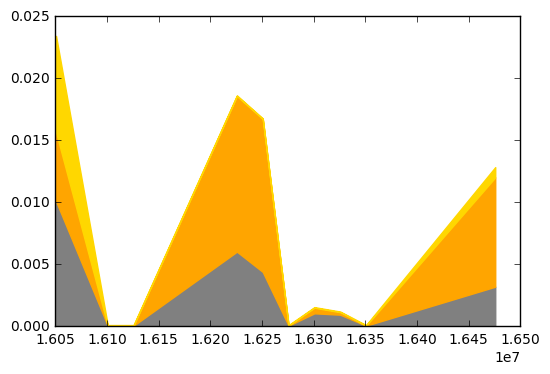

In [9]:
import pylab as pl
tot_var = df['Persistent Var'].values + df['Rescaling-GxC Var'].values + df['Heterogeneity-GxC var'].values
nohet_var = df['Persistent Var'].values + df['Rescaling-GxC Var'].values
wnd_start = sets['start'].values[:n_wnds].astype(int)
pl.fill_between(wnd_start, 0, df['Persistent Var'].values, color='gray')
pl.fill_between(wnd_start, df['Persistent Var'].values, nohet_var, color='Orange')
pl.fill_between(wnd_start, nohet_var, tot_var, color='Gold')

### P-values

For each test, empirical P values can be computed from the test statistics observed on the data and the null testistics using ``limix.stats.empirical_pvalues``.
See [here][1] for more info.

[1]: https://limix.readthedocs.io/stats.html#limix.stats.empirical_pvalues

In [10]:
from limix.stats import empirical_pvalues
#calculate P values for the three tests
for test in ['mtSet', 'iSet', 'iSet-het']:
    df[test+' pv'] = empirical_pvalues(df[test+' LLR'].values, df0[test+' LLR0'].values)

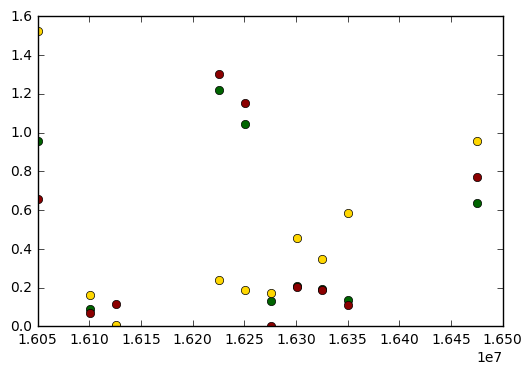

In [11]:
#makes a manhattan plot
wnd_start = sets['start'].values[:n_wnds].astype(int)
import pylab as pl
pl.plot(wnd_start, -sp.log10(df['mtSet pv'].values), 'o', color='DarkGreen')
pl.plot(wnd_start, -sp.log10(df['iSet pv'].values), 'o', color='DarkRed')
pl.plot(wnd_start, -sp.log10(df['iSet-het pv'].values), 'o', color='Gold')

## Stratified design

iSet is an extension of mtSet that allows to test for polygenic interactions with environment or other contexts.
iSet can be applied in designs where all individuals have been phenotyped in each context (complete design) as well as for populations that have been stratified by a context variable (stratified design).
We will here see application of iSet for analysis of stratified designs.

### Setting up

See above (complete design) for 

In [12]:
# activiate inline plotting
%matplotlib inline

import scipy as sp
import scipy.linalg
import pandas as pd
from limix.iSet.iset import fit_iSet
from limix.io import read_plink
from limix.util import sets_from_bim
from limix.util import unique_variants
import time

# import bed file
bfile = 'data/chrom22_subsample20_maf0.10'
(bim, fam, bed) = read_plink('data/chrom22_subsample20_maf0.10')

# defines sets using a sliding-window approach.
# window size = 50kb
# step = 25kb
# exclude regions with less than 4 variants.
sets = sets_from_bim(bim, size=50000, step=25000, minSnps=4)
print sets.head()

Reading data/chrom22_subsample20_maf0.10.bim... done (0.09 s)
Reading data/chrom22_subsample20_maf0.10.fam... done (0.00 s)
Reading data/chrom22_subsample20_maf0.10.bed... done (0.01 s)
  chr     start       end nsnps
0  22  16050612  16100612    23
1  22  16100612  16150612     4
2  22  16125612  16175612     7
3  22  16225612  16275612     9
4  22  16250612  16300612    16


### Import pheno data and covariates

Import phenotype data for $N=274$ individuals, each phenotyped in one of in $C=2$ contexts.

In [13]:
# import phenotype and sample relatedness
pheno_file = './data/pheno.phe'
Y = sp.loadtxt(pheno_file, usecols=[0])[:,sp.newaxis]

We also need to define a boolean ndarray indicator that specifies in which context each individuals is phenotyped.
For example, if we suppose that the first half of the individuals are phenotyped in context A and the second half in context B, we have:

In [14]:
Ie = sp.arange(Y.shape[0])<0.5*Y.shape[0]

The covariates include the first 10 principal components of the genetic relatedness matrix and
an intercept term ($K=11$ covariates in total).

In [15]:
covs_file = './data/covs.fe'
covs = sp.loadtxt(covs_file)

### Apply iSet

We here showcase how to run iSet on $T=10$ region-sets and $J=10$ parametric bootstrapts/permutations.
This last parameter determines the minimum P value that can be estimated.
For example, for $J=10$ and $T=10$ tests, the minimum P value is $1/JT=10^{-2}$.

The core function of the analysis is ``limix.iSet.fit_iSet``.
See [here][1] for more info.

[1]: https://limix.readthedocs.io/iSet.html

In [16]:
from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values=3.,
                  strategy='mean',
                  axis=0,
                  copy=False)

In [17]:
n_wnds = 10 # 10 region-sets are considered
n_nulls = 10 # number of bootstrapts/permutations 

# output is stored in pandas DataFrame
df = pd.DataFrame()
df0 = pd.DataFrame()

iter_sets = sets.iterrows()
for wnd_i in range(n_wnds):
    
    t0 = time.time()

    # extract geno info
    _, set = next(iter_sets)
    print('.. window %d - (%s, %d-%d) - %d snps' %
          (wnd_i, set['chr'], set['start'], set['end'], set['nsnps']))
    query = "chrom=='%s' & pos>=%d & pos<%d" % (set['chr'], set['start'], set['end'])
    chrom1 = bim.query(query)

    # impute, consider only unique variants and normalize
    Xr = imputer.fit_transform(Xr)
    Xr = unique_variants(Xr)
    Xr-= Xr.mean(0); Xr/= Xr.std(0)
    Xr/= sp.sqrt(Xr.shape[1])

    # run iSet
    _df, _df0 = fit_iSet(Y, F=covs, Xr=Xr, Ie=Ie, n_nulls=10)
    df  = df.append(_df, ignore_index=True)
    df0 = df0.append(_df0, ignore_index=True)
    
    print 'Elapsed:', time.time()-t0

.. window 0 - (22, 16050612-16100612) - 23 snps
Elapsed: 5.42739009857
.. window 1 - (22, 16100612-16150612) - 4 snps
Elapsed: 5.3012650013
.. window 2 - (22, 16125612-16175612) - 7 snps
Elapsed: 5.80481314659
.. window 3 - (22, 16225612-16275612) - 9 snps
Elapsed: 5.12378621101
.. window 4 - (22, 16250612-16300612) - 16 snps
Elapsed: 5.35974884033
.. window 5 - (22, 16275612-16325612) - 12 snps
Elapsed: 5.10933494568
.. window 6 - (22, 16300612-16350612) - 4 snps
Elapsed: 5.33015298843
.. window 7 - (22, 16325612-16375612) - 5 snps
Elapsed: 5.95581889153
.. window 8 - (22, 16350612-16400612) - 5 snps
Elapsed: 5.64678382874
.. window 9 - (22, 16475612-16525612) - 8 snps
Elapsed: 6.71362280846


The dataframes df and df0 have the same structures as in the complete design case.
Please see above for the format of the output and plotting examples.

# Developers

- Francesco Paolo Casale (<casale@ebi.ac.uk>)
- Danilo Horta (<horta@ebi.ac.uk>)
- Barbara Rakitsch (<rakitsch@ebi.ac.uk>)
- Oliver Stegle (<stegle@ebi.ac.uk>)